<a href="https://colab.research.google.com/github/LeandroJorquera/synthetic_L1/blob/main/emb_visualization_sklearn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle

In [2]:
def load_and_reformat(path_emb, path_labels):
    """Load emb and counts df and reformatting to make them suitable for merge"""
    # Load and reformat embeddings from pickle file
    emb_input = pd.read_pickle(path_emb)
        
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v

    # Load and reformat labels df
    labels = pd.read_csv(path_labels)
    
    reformatted_labels_dict = {}
    counts = labels['Non_redundant']
    names = labels['ID']
    taxa = labels['Taxonomy']
    prot_len = labels['prot_len']
    for i in range(len(labels)):
        cn = counts[i]
        ID = names[i]
        species = taxa[i]
        protein_length = prot_len[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        reformatted_labels_dict[clean] = cn, species, protein_length

    a = pd.DataFrame.from_dict(reformatted_labels_dict, orient='index')
    reformatted_labels = a.reset_index()
    reformatted_labels.columns = ['ID','Non_redundant','Taxonomy', 'prot_len']
    
    # Combine embeddings and ORF2 counts
    matrix_inverted = pd.DataFrame(reformatted_emb)
    a = matrix_inverted.transpose()
    b = a.reset_index()
    matrix = b.rename(columns={'index':'ID'})
    
    return reformatted_emb, reformatted_labels, matrix

**Read dataset, labels and cleaning**

In [3]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path_emb = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/embeddings_v2.pickle'
path_labels = '/Users/leandrojorqueravalero/Desktop/PhD/synthetic_ORF2/data/labels.csv'

reformat = load_and_reformat(path_emb, path_labels)

In [4]:
reformatted_emb = reformat[0]
reformatted_labels = reformat[1]
matrix = reformat[2]

**Add labels to dataset**

In [5]:
# -- Matching datasets
labelled_embs = pd.merge(matrix, reformatted_labels)

In [6]:
# -- Removing ID and labels column for reduction
X = labelled_embs.drop(columns=['ID','Non_redundant','Taxonomy', 'prot_len'])

**Apply dimensionality reduction to data and plot results**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

In [77]:
def DR(X, method):
    """Define a function to run dimensionality reduction and visualize"""
    # Define color maps for counts and protein length
    counts_cmap = matplotlib.colormaps["inferno"]
    len_cmap = matplotlib.colormaps["viridis"]
    
    # Create figure and color scales for counts and protein length labels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
    sm = matplotlib.cm.ScalarMappable(cmap=counts_cmap)
    sm2 = matplotlib.cm.ScalarMappable(cmap=len_cmap)
    
    # Standardize (normalize) features
    StandardScaler().fit_transform(X)
    
    if method == 'pca':
        # Define PCA reduction and apply on normalized data
        pca = PCA(n_components=2)
        X_dr = pca.fit_transform(X)
        var_expl = pca.explained_variance_ratio_
        
    elif method == 'umap':
        # Define UMAP and apply on normalized data
        X_dr = umap.UMAP(n_neighbors=30, densmap=True).fit_transform(X)
        
    elif method == 'tsne':
        # Define t-SNE and apply on normalized data
        X_dr = TSNE(n_components=2).fit_transform(X)
    
    # Plot dimensionality reduction results
    # Label counts
    ax1.scatter(X_dr[:, 0], X_dr[:, 1], s=10, c=labelled_embs["Non_redundant"], cmap=counts_cmap) # cmap=counts_cmap
    sm.set_norm(plt.Normalize(vmin=min(labelled_embs["Non_redundant"]), vmax=max(labelled_embs["Non_redundant"])))
    cbar = plt.colorbar(sm, ax=ax1, fraction=0.046)
    ax1.set_title('Non-redundant counts')
    ax1.set_xlabel(f'{method.upper()} 1 ') # ({int(var_expl[0]*100)}%)
    ax1.set_ylabel(f'{method.upper()} 2 ') # ({int(var_expl[1]*100)}%)
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Label protein length
    ax2.scatter(X_dr[:, 0], X_dr[:, 1], s=10, c=labelled_embs["prot_len"], cmap=len_cmap) #cmap=len_cmap
    sm2.set_norm(plt.Normalize(vmin=min(labelled_embs["prot_len"]), vmax=max(labelled_embs["prot_len"])))
    cbar2 = plt.colorbar(sm2, ax=ax2, fraction=0.046)
    ax2.set_title('Protein length (aa)')
    ax2.set_xlabel(f'{method.upper()} 1')
    ax2.set_ylabel(f'{method.upper()} 2')
    ax2.set_xticks([])
    ax2.set_yticks([])


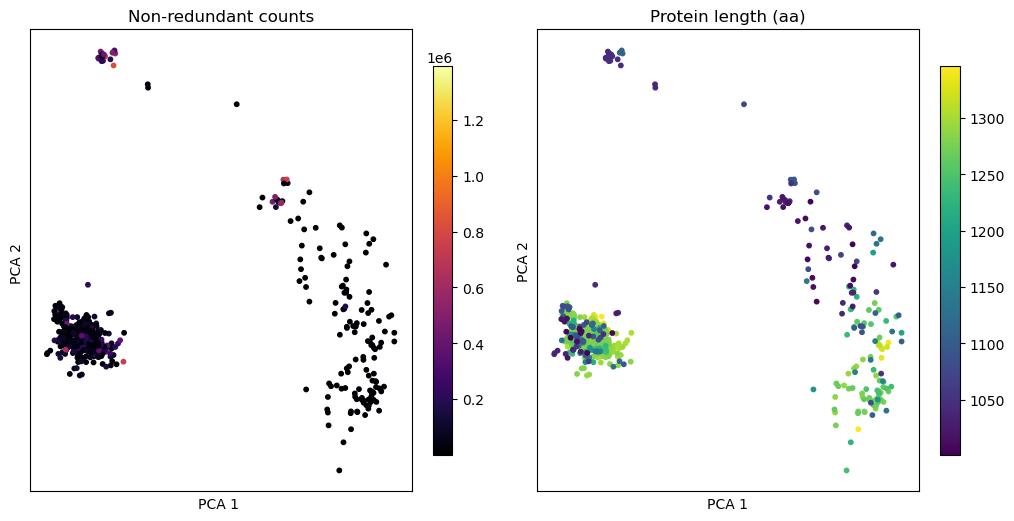

In [78]:
DR(X,method='pca')

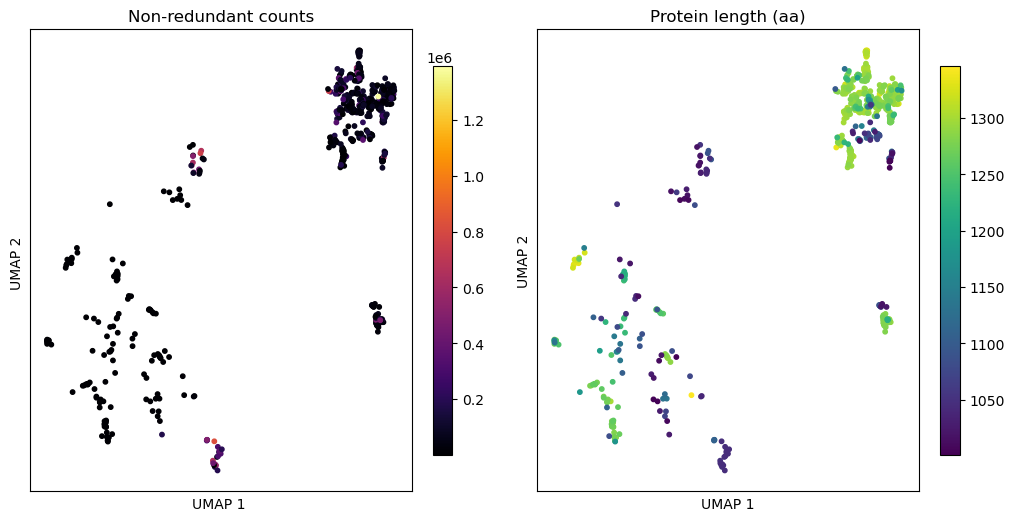

In [79]:
DR(X,method='umap')

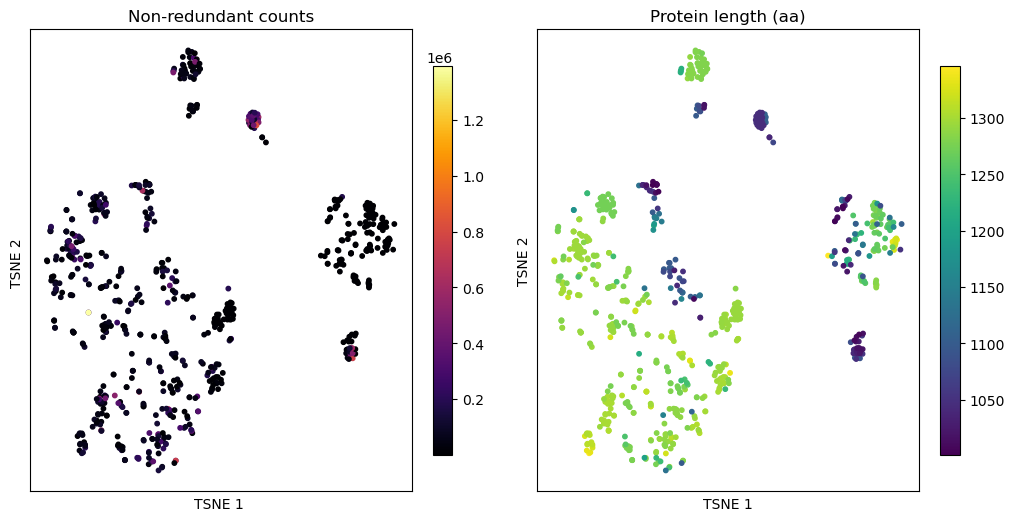

In [80]:
DR(X,method='tsne')